<a href="https://colab.research.google.com/github/VincentGaoHJ/Course-CS5242/blob/master/practice_7_handseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice 7: Hand Segmentation

In [27]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Data, Dataset and DataLoader

Then we will train our model on a combined dataset comprising of [GTEA](http://cbs.ic.gatech.edu/fpv/) and [Hand over Face (HOF)](https://github.com/aurooj/Hand-Segmentation-in-the-Wild) datasets.

| Stat           | GTEA | HandOverFace |
| :--:           | :--: | :----------: |
| frames         | 663  | 300          |
| hand instances | 1231 | 507          |

In [ ]:
# !wget https://www.comp.nus.edu.sg/~rchen/cs5242/hand_dataset.zip -P /content/drive/MyDrive/data

--2021-03-09 08:52:03--  https://www.comp.nus.edu.sg/~rchen/cs5242/hand_dataset.zip
Resolving www.comp.nus.edu.sg (www.comp.nus.edu.sg)... 45.60.31.225
Connecting to www.comp.nus.edu.sg (www.comp.nus.edu.sg)|45.60.31.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130062587 (124M) [application/zip]
Saving to: ‘/content/drive/MyDrive/data/hand_dataset.zip’

hand_dataset.zip    100%[===================>] 124.04M   519KB/s    in 4m 9s   

2021-03-09 08:56:14 (510 KB/s) - ‘/content/drive/MyDrive/data/hand_dataset.zip’ saved [130062587/130062587]



In [28]:
import os
import zipfile


# Check whether hand_dataset.zip is unzipped
if not os.path.isdir('/content/drive/MyDrive/data/hand_dataset'):
    with zipfile.ZipFile('/content/drive/MyDrive/data/hand_dataset.zip', 'r') as f:
        f.extractall('/content/drive/MyDrive/data')

The file structure is shown here,

| drive/MyDrive/data

----| hand_dataset

--------| GTEA

------------| Images

------------| Masks

------------| ...

--------| hand_over_face

------------| images_resized

------------| masks

------------| ...

In [9]:
import glob

import cv2
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

In [32]:
GTEA_DSDIR = '/content/drive/MyDrive/data/hand_dataset/GTEA'
HOF_DSDIR = '/content/drive/MyDrive/data/hand_dataset/hand_over_face'

**Visualize one sample and mask in each dataset.**

In [33]:
# Configure Directory info
GTEA_SAMPLE_DIR = os.path.join(GTEA_DSDIR, 'Images')
GTEA_MASK_DIR = os.path.join(GTEA_DSDIR, 'Masks')
HOF_SAMPLE_DIR = os.path.join(HOF_DSDIR, 'images_resized')
HOF_MASK_DIR = os.path.join(HOF_DSDIR, 'masks')

# config GTEA sample and mask
gtea_file = os.listdir(GTEA_SAMPLE_DIR)[1]
gtea_sample = os.path.join(GTEA_SAMPLE_DIR, gtea_file)
gtea_masks = os.path.join(GTEA_MASK_DIR, gtea_file)
gtea_masks = gtea_masks[:-3] + 'png' # change jpg to png

# config HOF sample and mask
hof_file = os.listdir(HOF_SAMPLE_DIR)[0]
hof_sample = os.path.join(HOF_SAMPLE_DIR, hof_file)
hof_masks = os.path.join(HOF_MASK_DIR, hof_file)
hof_masks = hof_masks[:-3] + 'png' # change jpg to png

# save as tuple
sample_mask_pair = [(gtea_sample, gtea_masks, 'GTEA'),
                    (hof_sample, hof_masks, 'HOF')]

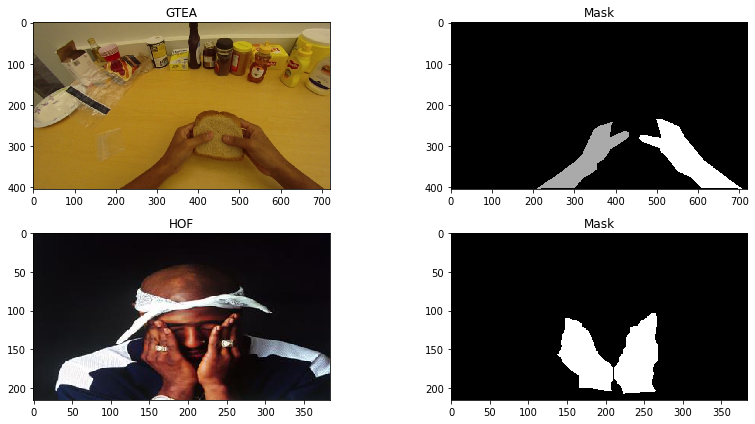

In [ ]:
high, width = len(sample_mask_pair), 2

fig, axes = plt.subplots(high, width, figsize=(width*6, high*3), tight_layout=True)
for row in range(high):
    for col in range(width):
        image_name = sample_mask_pair[row][col]
        img = plt.imread(image_name)
        axes[row, col].imshow(img)
        title = sample_mask_pair[row][2]
        title = "Mask" if col == 1 else title
        axes[row, col].set_title(title)
plt.show()

**Customize the segmentation dataset and dataloader. Ref: [PyTorch tutorials](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataset).**

- You can first get the list of image paths and mask paths.

- Split the train and validation dataset according to ratio `9:1`.

- In `__getitem__`, load data from the path using `(PIL.)Image.open`.

- Resize the image into `288 × 384` and normalize with `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`.

- We only care about hands and background, which means there are 2 classes.

- Use `batch_size = 2`. A small batch size is common in the segmentation task.

In [117]:
# https://towardsdatascience.com/semantic-hand-segmentation-using-pytorch-3e7a0a0386fa
class SegDataset(Dataset):
    """
    Split the train and validation dataset according to ratio 9:1.
    Resize the image into 288 × 384 and normalize with mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225].
    We only care about hands and background, which means there are 2 classes.
    Use batch_size = 2. A small batch size is common in the segmentation task.
    """
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_list = glob.glob(image_dir+'/*')
        self.mask_list = glob.glob(mask_dir+'/*')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        """
        Get both the image and mask
        """
        # We resize and standardize the image and get X. 
        # For the mask, which is also our label, we resize and standardize the image. 
        preprocess_img = transforms.Compose(
            [transforms.Resize((384, 288)),
             transforms.ToTensor(),
             transforms.Normalize(
                 mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225])])
        
        preprocess_mask = transforms.Compose(
            [transforms.Resize((384, 288)),
             transforms.ToTensor()])
        
        # Load data from the path using (PIL.)Image.open.
        image = Image.open(self.image_list[idx]).convert('RGB') # if you want and expect an RGB image, you should just convert to RGB on opening
        label = Image.open(self.mask_list[idx]).convert('L') # L means "Luminance" which is just a fancy way of saying "brightness" on a scale of black to white
        image = preprocess_img(image)
        label = preprocess_mask(label)
        
        # Further construct label
        label = label.type(torch.BoolTensor)
        label_nonhand = torch.bitwise_not(label) # Get another mask that is the negative of the original one
        label = torch.cat([label_nonhand, label], dim=0)

        # sample = {"image": image, "label": label}
        return image, label

In [4]:
#TTR is Train Test Ratio
from torch.utils.data import Subset
def trainTestSplit(dataset, TTR):
    total = len(dataset)
    split_idx = int(TTR * total)
    train_dataset = Subset(dataset, range(0, split_idx))
    test_dataset = Subset(dataset, range(split_idx, total))
    return train_dataset, test_dataset

### Model

**We use [DeepLabV3](https://arxiv.org/pdf/1706.05587.pdf) model: `models.segmentation.deeplabv3_resnet50`. (#class = 2, hands and background)**

DeepLabV3 = ResNet + DeepLabHead. We use an IN-pretrained ResNet backbone.

![](https://miro.medium.com/max/2400/1*8Lg66z7e7ijuLmSkOzhYvA.png)

In [5]:
from torchvision import models
deeplab = models.segmentation.deeplabv3_resnet50(
    pretrained=0,  progress=1, num_classes=2)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [7]:
print(deeplab)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Then we write a custom model to process the data.

In [18]:
class HandSegModel(nn.Module):
    def __init__(self, model):
        super(HandSegModel,self).__init__()
        self.dl = model
        
    def forward(self, x):
        return self.dl(x)['out']

### Metrics

![](https://www.comp.nus.edu.sg/~rchen/cs5242/segmetrics.png)

**HINT:** You may find `logical_and/or` helpful.

In [13]:
# We would use Intersection over Union and Pixel Accuracy as our metrics for this task. 
# IOU is a standard metric for segmentation tasks.
def meanIOU(target, predicted):
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    iousum = 0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        intersection = np.logical_and(target_arr, predicted_arr).sum()
        union = np.logical_or(target_arr, predicted_arr).sum()
        if union == 0:
            iou_score = 0
        else :
            iou_score = intersection / union
        iousum +=iou_score
        
    miou = iousum/target.shape[0]
    return miou

In [14]:
# Pixel accuracy is simply the number of correctly predicted pixels 
# divided by total number of pixels.
def pixelAcc(target, predicted):    
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    accsum=0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        same = (target_arr == predicted_arr).sum()
        a, b = target_arr.shape
        total = a*b
        accsum += same/total
    
    pixelAccuracy = accsum/target.shape[0]        
    return pixelAccuracy

### Training

**Implement the training loop.**

In [121]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader, lastCkptPath=None):

    # Configure CUDA
    dev = "cuda:0"  if torch.cuda.is_available() else "cpu"
    device = torch.device(dev)

    # Initialize variables
    tr_loss_arr, val_loss_arr = [], []
    meanioutrain, meanioutest = [], []
    pixelacctrain, pixelacctest = [], []
    prevEpoch = 0
    
    # Resume the model from the path
    if lastCkptPath != None :
        # read epoch info
        checkpoint = torch.load(lastCkptPath)
        prevEpoch = checkpoint['epoch']
        # load checkpoint info into model and optimizer
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
                    
        # Load variables
        tr_loss_arr = checkpoint['Training Loss']
        val_loss_arr =  checkpoint['Validation Loss']
        meanioutrain =  checkpoint['MeanIOU train']
        pixelacctrain =  checkpoint['PixelAcc train']
        meanioutest =  checkpoint['MeanIOU test']
        pixelacctest =  checkpoint['PixelAcc test']
        print("loaded model, ", checkpoint['description'], "at epoch", prevEpoch)
    
    # Prevent: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
    model.to(device)

    # Training and evaluation
    for epoch in range(0, n_epochs):
        train_loss = 0.0
        pixelacc = 0
        meaniou = 0
        
        pbar = tqdm(train_loader, total = len(train_loader))
        for X, y in pbar:
            torch.cuda.empty_cache()
            model.train()
            X = X.to(device).float()
            y = y.to(device).float()
            ypred = model(X)
            loss = loss_fn(ypred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tr_loss_arr.append(loss.item())
            meanioutrain.append(meanIOU(y, ypred))
            pixelacctrain.append(pixelAcc(y, ypred))
            pbar.set_postfix({'Epoch':epoch+1+prevEpoch, 
                              'Training Loss': np.mean(tr_loss_arr),
                              'Mean IOU': np.mean(meanioutrain),
                              'Pixel Acc': np.mean(pixelacctrain)
                             })
            
        with torch.no_grad():
            val_loss = 0
            pbar = tqdm(val_loader, total = len(val_loader))
            for X, y in pbar:
                torch.cuda.empty_cache()
                X = X.to(device).float()
                y = y.to(device).float()
                model.eval()
                ypred = model(X)
                
                val_loss_arr.append(loss_fn(ypred, y).item())
                pixelacctest.append(pixelAcc(y, ypred))
                meanioutest.append(meanIOU(y, ypred))
                
                pbar.set_postfix({'Epoch':epoch+1+prevEpoch, 
                                  'Validation Loss': np.mean(val_loss_arr),
                                  'Mean IOU': np.mean(meanioutest),
                                  'Pixel Acc': np.mean(pixelacctest)
                                 })
        
        
        
        checkpoint = {
            'epoch':epoch+1+prevEpoch,
            'description':"add your description",
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training Loss': tr_loss_arr,
            'Validation Loss':val_loss_arr,
            'MeanIOU train':meanioutrain, 
            'PixelAcc train':pixelacctrain, 
            'MeanIOU test':meanioutest, 
            'PixelAcc test':pixelacctest
        }
        torch.save(checkpoint, 'checkpoints/checkpointhandseg'+str(epoch+1+prevEpoch)+'.pt')
        lr_scheduler.step()
        
    return tr_loss_arr, val_loss_arr, meanioutrain, pixelacctrain, meanioutest, pixelacctest

**Use `Adam` optimizer with a small finetuning `lr = 1e-4`. Use `Exponential LR Decay scheduler` with rate 0.9.**

In [21]:
model = HandSegModel(deeplab)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

In [24]:
print(f'optimizer: {optimizer}')
print(f'loss_fn: {loss_fn}')
print(f'lr_scheduler: {lr_scheduler}')

optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    weight_decay: 0
)
loss_fn: BCEWithLogitsLoss()
lr_scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x7f45c93c5610>


It takes ~20 min to train 3 epochs.

In [118]:
# Combine multiple datasets into one
HOFdataset = SegDataset(HOF_SAMPLE_DIR, HOF_MASK_DIR)
GTEAdataset = SegDataset(GTEA_SAMPLE_DIR, GTEA_MASK_DIR)
print(f'Total {len(HOFdataset)} samples in HOF dataset')
print(f'Total {len(GTEAdataset)} samples in GTEA dataset')
megaDataset = ConcatDataset([HOFdataset, GTEAdataset])
print(f'Total {len(megaDataset)} samples in mega dataset')

Total 300 samples in HOF dataset
Total 663 samples in GTEA dataset
Total 963 samples in mega dataset


In [119]:
# Split the dataset and create two dataloaders for the train and validation datasets.
batchSize = 2
trainDataset, valDataset = trainTestSplit(megaDataset, 0.9)
trainLoader = DataLoader(trainDataset, batch_size = batchSize, shuffle=True, drop_last=True)
valLoader = DataLoader(valDataset, batch_size = batchSize, shuffle=True, drop_last=True)

In [ ]:
if not os.path.isdir('checkpoints'):
    !mkdir checkpoints

retval = training_loop(
    3, optimizer, lr_scheduler, model, loss_fn, 
    trainLoader, valLoader)

# retval = training_loop(
#     3, optimizer, lr_scheduler, model, loss_fn, 
#     trainLoader, valLoader, 
#     'checkpoints/checkpointhandseg.pt')

Visualize the training process.

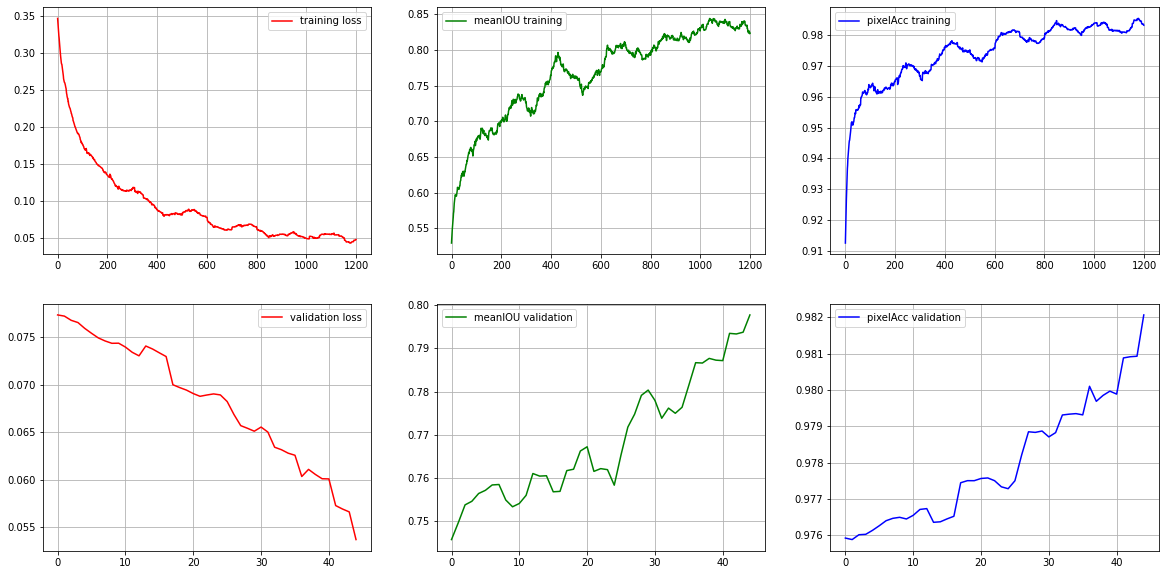

### Inference

In [ ]:
#can pass np array or path to image file
def SegmentHands(pathtest):


























    return mask

**Visualize the prediction mask.**

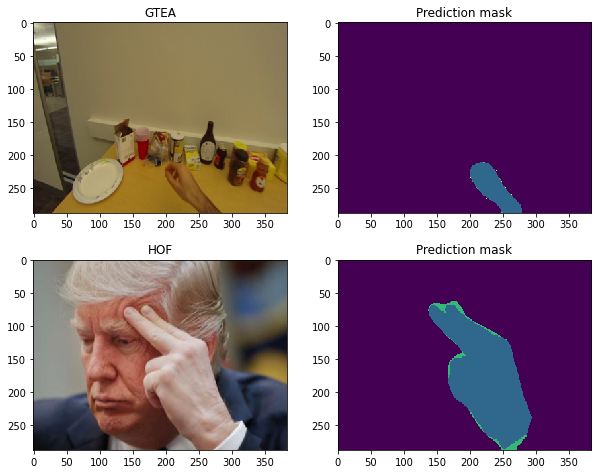